In [1]:
#-- Sample 32 Frames --
#-- Resize  --
#-- Augmentation: Brightness --

In [2]:
#-- Imports ------------------------------------------------------------------------------------------------------
import cv2
import matplotlib.pyplot as plt

import numpy as np
import random

import os
import shutil
import copy
#-----------------------------------------------------------------------------------------------------------------

In [3]:
#-- Initialize ---------------------------------------------------------------------------------------------------
ds_input_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/'

NUM_FRAMES = 32
FRAME_W = 256
FRAME_H = 256

CLASS_NAMES = ['Violence', 'NonViolence']

ORIGIN = True
NOISY = True
BRIGHT = True
NOISY_BRIGHT = True
BLUR = True

if ORIGIN:
    ds_result_path = '/kaggle/working/ds_origin'
    
if NOISY:
    ds_result_path = '/kaggle/working/ds_noisy'

if BRIGHT:   
    ds_result_path = '/kaggle/working/ds_birght'

if NOISY_BRIGHT:
    ds_result_path = '/kaggle/working/ds_noisy_birght'

if BLUR:
    ds_result_path = '/kaggle/working/ds_blur'
#-----------------------------------------------------------------------------------------------------------------

In [17]:
#-- Select Samples for each Augmentation -------------------------------------------------------------------------
if not ORIGIN:
    random.seed(42)
    
    violence_files_list = os.listdir('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence')
    non_violence_files_list = os.listdir('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence')

    violence_files_list = sorted(violence_files_list)
    non_violence_files_list = sorted(non_violence_files_list)

    num_items = 250

    v_noisy = random.choices(violence_files_list, k=num_items)
    v_bright = random.choices(violence_files_list, k=num_items)
    v_noisy_bright = random.choices(violence_files_list, k=num_items)
    v_blur = random.choices(violence_files_list, k=num_items)

    nv_noisy = random.choices(non_violence_files_list, k=num_items)
    nv_bright = random.choices(non_violence_files_list, k=num_items)
    nv_noisy_bright = random.choices(non_violence_files_list, k=num_items)
    nv_blur = random.choices(non_violence_files_list, k=num_items)
    
    random.seed(None)
#-----------------------------------------------------------------------------------------------------------------

In [5]:
#-- Function to Add Noise ----------------------------------------------------------------------------------------
def add_noise(image, factor):
    noise = np.random.normal(0, factor, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image
#-----------------------------------------------------------------------------------------------------------------

In [6]:
#-- Function to Change Brightness --------------------------------------------------------------------------------
def adjust_brightness(image, factor):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)
#-----------------------------------------------------------------------------------------------------------------

In [7]:
#-- Function to Add Noise and Change Brightness ------------------------------------------------------------------
def apply_noise_and_brightness(image, nois_factor, bright_factor):
    noisy_image = add_noise(image, nois_factor)     
    return adjust_brightness(noisy_image, bright_factor)
#-----------------------------------------------------------------------------------------------------------------

In [8]:
#-- Funvtion to Apply Blur ---------------------------------------------------------------------------------------
def apply_blur(image, kernel_size=(7, 7)):    
    return cv2.GaussianBlur(image, kernel_size, 0)
#-----------------------------------------------------------------------------------------------------------------

In [9]:
#-- Function to Normalize Pixel Values to the range [0, 1] -------------------------------------------------------
def normalize_image(image):
    return image.astype(np.float32) / 255.0
#-----------------------------------------------------------------------------------------------------------------

In [10]:
#-- ّFunction to sample frames ------------------------------------------------------------------------------------
def sample_frames(frames, num_samples):    
    return random.sample(range(len(frames)), num_samples)
#-----------------------------------------------------------------------------------------------------------------

In [11]:
#-- function to plot Sampled Videos ------------------------------------------------------------------------------
def plot_samples(original_samples, noisy_samples, bright_samples, noisy_bright_samples, blur_samples, num_samples_to_plot=5):
    fig, axes = plt.subplots(num_samples_to_plot, 5, figsize=(10, num_samples_to_plot * 2))

    for i in range(num_samples_to_plot):
        #-- Original Samples --
        axes[i, 0].imshow(original_samples[i])
        axes[i, 0].set_title(f'Original {i + 1}')
        axes[i, 0].axis('off')

        #-- Noisy Samples --
        axes[i, 1].imshow(noisy_samples[i])
        axes[i, 1].set_title(f'Noisy {i + 1}')
        axes[i, 1].axis('off')

        #-- Bright Samples --
        axes[i, 2].imshow(bright_samples[i])
        axes[i, 2].set_title(f'Dark {i + 1}')
        axes[i, 2].axis('off')

        #-- noisy and bright Samples --
        axes[i, 3].imshow(noisy_bright_samples[i])
        axes[i, 3].set_title(f'Noisy and Dark {i + 1}')
        axes[i, 3].axis('off')
        
        #-- Blur Samples --
        axes[i, 4].imshow(blur_samples[i])
        axes[i, 4].set_title(f'Blur {i + 1}')
        axes[i, 4].axis('off')
        
        

    plt.tight_layout()
    plt.show()
#-----------------------------------------------------------------------------------------------------------------

In [12]:
#-- Function to Process a single video and return sampled frames as numpy arrays --------------------------------
def process_video(video_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, resize)
        frames.append(frame_resized)

    cap.release()

    #-- Sample frames --
    if ORIGIN:
        sampled_indices_original = sample_frames(frames, num_frames)
    if NOISY:
        sampled_indices_noisy = sample_frames(frames, num_frames)
    if BRIGHT:
        sampled_indices_bright = sample_frames(frames, num_frames)
    if NOISY_BRIGHT:
        sampled_indices_brihgt_and_noisy = sample_frames(frames, num_frames)
    if BLUR:
        sampled_indices_blur = sample_frames(frames, num_frames)

    #-- Create arrays to store the samples --
    original_samples = np.zeros((num_frames, FRAME_W, FRAME_H, 3), dtype=np.float32)
    noisy_samples = np.zeros((num_frames, FRAME_W, FRAME_H, 3), dtype=np.float32)
    bright_samples = np.zeros((num_frames, FRAME_W, FRAME_H, 3), dtype=np.float32)
    bright_and_noisy_samples = np.zeros((num_frames, FRAME_W, FRAME_H, 3), dtype=np.float32)
    blur_samples = np.zeros((num_frames, FRAME_W, FRAME_H, 3), dtype=np.float32)

    if NOISY or BRIGHT or NOISY_BRIGHT:
        noise_factor = random.randint(3, 8)    
        bright_factor = random.uniform(0.2, 0.7)    
        print(f'noise_factor: {noise_factor}\nbright_factor: {bright_factor}')
    
    for i in range(num_frames):
        #-- Original Frame --
        if ORIGIN:
            original_samples[i] = normalize_image(frames[sampled_indices_original[i]])

        #-- Noisy Frame --    
        if NOISY:
            noisy_samples[i] = normalize_image(add_noise(frames[sampled_indices_noisy[i]], noise_factor))

        #-- Bright Frame --   
        if BRIGHT:
            bright_samples[i] = normalize_image(adjust_brightness(frames[sampled_indices_bright[i]], bright_factor))

        #-- Nosiy and Brightness Frame --        
        if NOISY_BRIGHT:
            bright_and_noisy_samples[i] = normalize_image(adjust_brightness(add_noise(frames[sampled_indices_brihgt_and_noisy[i]],
                                                                          noise_factor),
                                                                bright_factor))
        #-- Blur Frame --
        if BLUR:
            blur_samples[i] = normalize_image(apply_blur(frames[sampled_indices_blur[i]]))

    return original_samples, noisy_samples, bright_samples, bright_and_noisy_samples, blur_samples
#-----------------------------------------------------------------------------------------------------------------

In [18]:
#-- Function to Preprocess All Videos in DS ----------------------------------------------------------------------
def process_all_videos(video_dir, output_dir, num_frames=NUM_FRAMES):   
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for label in CLASS_NAMES:
        label_dir = os.path.join(video_dir, label)
        output_label_dir = os.path.join(output_dir, label)
        if not os.path.exists(output_label_dir):
            os.makedirs(output_label_dir)

        if ORIGIN:
            video_file_list = os.listdir(label_dir)
        
        if NOISY:
            if label == 'Violence':
                video_file_list = v_noisy
            else:
                video_file_list = nv_noisy
        
        if BRIGHT:
            if label == 'Violence':
                video_file_list = v_bright
            else:
                video_file_list = nv_bright
        
        if NOISY_BRIGHT:
            if label == 'Violence':
                video_file_list = v_noisy_bright
            else:
                video_file_list = nv_noisy_bright
        
        if BLUR:
            if label == 'Violence':
                video_file_list = v_blur
            else:
                video_file_list = nv_blur            
        
        for video_file in video_file_list:            
            video_path = os.path.join(label_dir, video_file)
            original_samples, noisy_samples, bright_samples, bright_and_noisy_samples, blur_samples = process_video(video_path,
                                                                                                                    num_frames)
            
            plot_samples(original_samples, noisy_samples, bright_samples, bright_and_noisy_samples, blur_samples)
                        
            #-- Save samples for each video --  
            if ORIGIN:
                np.save(os.path.join(output_label_dir, f"original_{video_file.replace('.mp4', '.npy')}"), original_samples)
            if NOISY:
                np.save(os.path.join(output_label_dir, f"noisy_{video_file.replace('.mp4', '.npy')}"), noisy_samples)
            if BRIGHT:
                np.save(os.path.join(output_label_dir, f"bright_{video_file.replace('.mp4', '.npy')}"), bright_samples)
            if NOISY_BRIGHT:
                np.save(os.path.join(output_label_dir, f"bright_noisy_{video_file.replace('.mp4', '.npy')}"), bright_and_noisy_samples)
            if BLUR:
                np.save(os.path.join(output_label_dir, f"blur_{video_file.replace('.mp4', '.npy')}"), blur_samples)
                                   
            break
#-----------------------------------------------------------------------------------------------------------------

noise_factor: 7
bright_factor: 0.6511047768257305


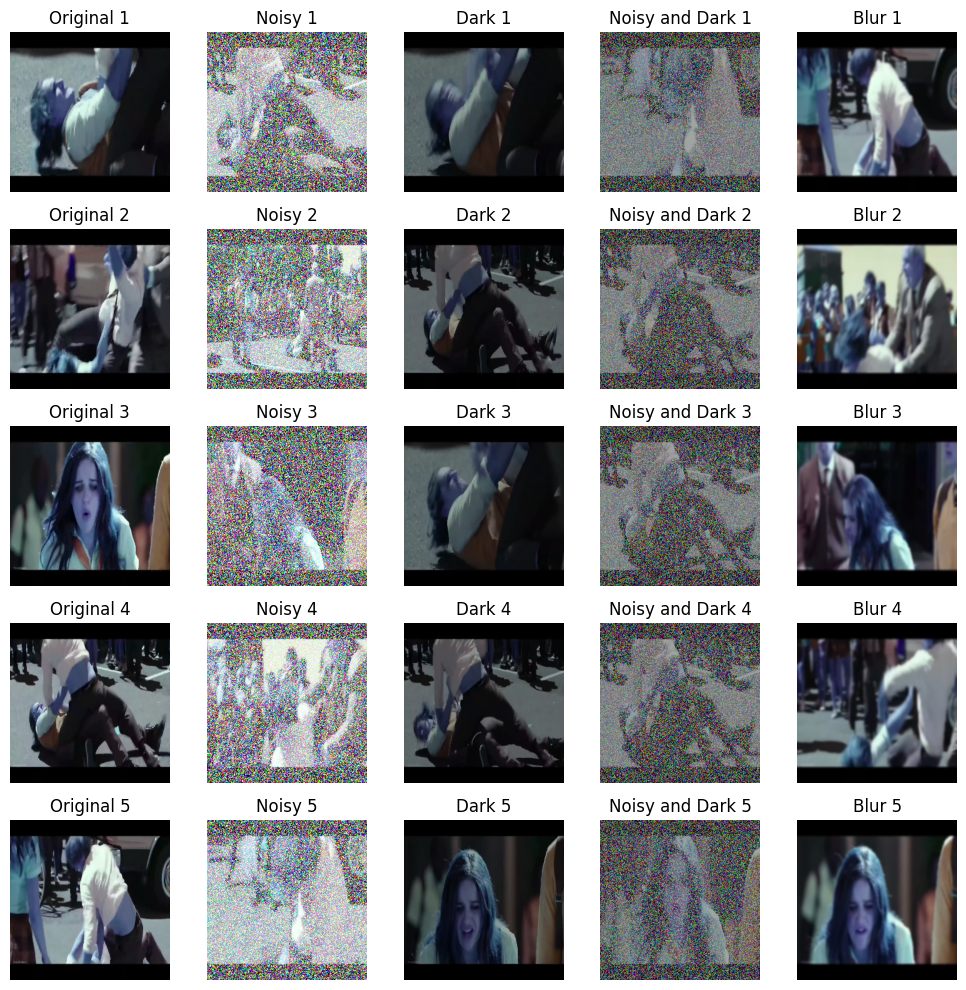

noise_factor: 3
bright_factor: 0.6288725620436455


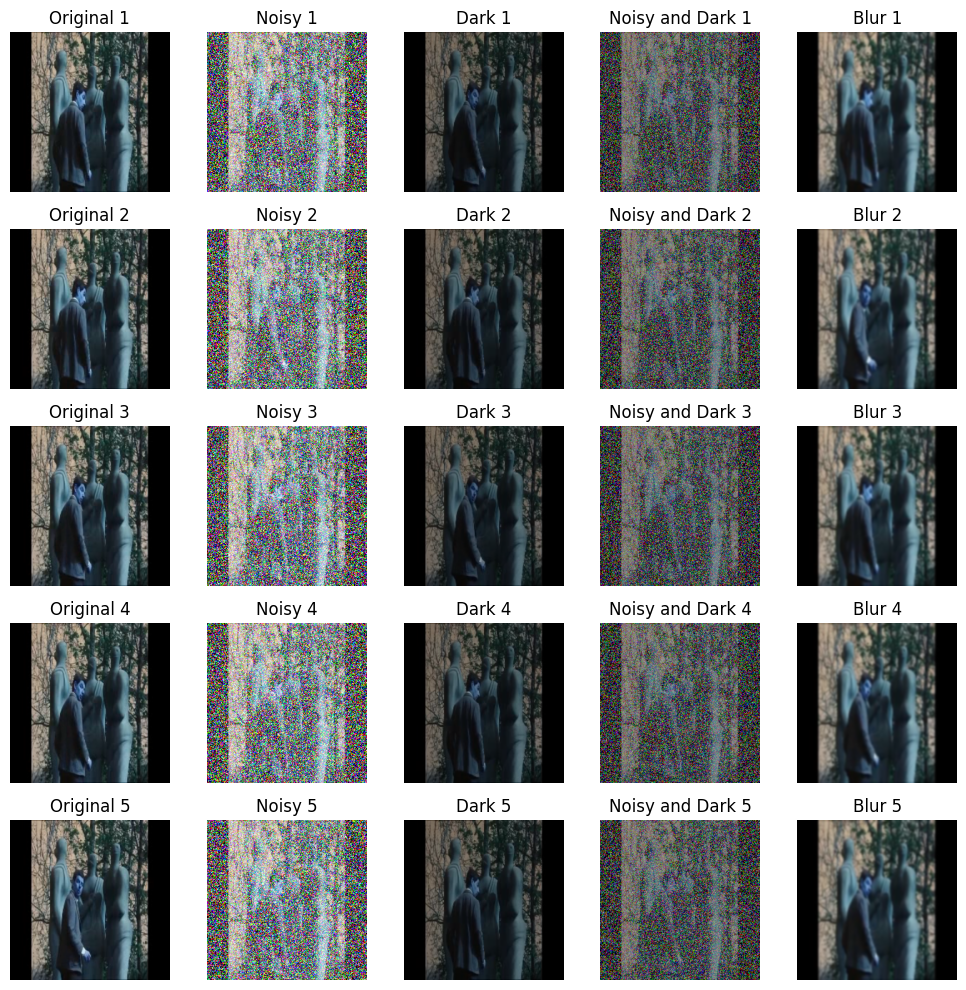

In [20]:
process_all_videos(ds_input_path, ds_result_path)

In [ ]:
#-- Zip Data -----------------------------------------------------------------------------------------------------
if ORIGIN:
    ds_zip_file = '/kaggle/working/data_origin'

if NOISY:
    ds_zip_file = '/kaggle/working/data_noisy'

if BRIGHT:
    ds_zip_file = '/kaggle/working/data_bright'

if NOISY_BRIGHT:
    ds_zip_file = '/kaggle/working/data_noisy_bright'

if BLUR:
    ds_zip_file = '/kaggle/working/data_blur'

shutil.make_archive(ds_zip_file, 'zip', ds_result_path)
shutil.rmtree(ds_result_path)
#-------------------------------------------------------------------------------------------------------------